Here we will compare different samplig methods for the target `donut_target`, specifically the ess method 

### Importing the needed libraries 

In [5]:
from cuqi.distribution import DistributionGallery, Gaussian, JointDistribution
from cuqi.testproblem import Poisson1D
from cuqi.problem import BayesianProblem
import cuqi
import inspect
import numpy as np
import matplotlib.pyplot as plt
from cuqi.sampler import MH, CWMH, ULA, MALA, NUTS
import time
import scipy.stats as sps
from scipy.stats import gaussian_kde
import pandas as pd

### The donut distribution


In [6]:
# The donut distribution 
target_donut = DistributionGallery("donut")

# The Poisson1D Bayesian problem
dim = 201
L = np.pi

xs = np.array([0.2, 0.4, 0.6, 0.8])*L
ws = 0.8
sigma_s = 0.05
def f(t):
    s = np.zeros(dim-1)
    for i in range(4):
        s += ws * sps.norm.pdf(t, loc=xs[i], scale=sigma_s)
    return s

A, _, _ = Poisson1D(dim=dim, 
                    endpoint=L,
                    field_type='KL',
                    field_params={'num_modes': 10} ,
                    map=lambda x: np.exp(x), 
                    source=f).get_components()
sigma_x = 30
x = Gaussian(0, sigma_x**2, geometry=A.domain_geometry)
np.random.seed(12)
x_true = x.sample()
sigma_y = np.sqrt(0.001)
y = Gaussian(A(x), sigma_y**2, geometry=A.range_geometry)
y_obs = y(x=x_true).sample()
joint = JointDistribution(y, x)
target_poisson = joint(y=y_obs)

In [7]:
[sampler for sampler in dir(cuqi.sampler) if not sampler.startswith('_')]

['CWMH',
 'Conjugate',
 'ConjugateApprox',
 'Gibbs',
 'LinearRTO',
 'MALA',
 'MH',
 'NUTS',
 'ProposalBasedSampler',
 'RegularizedLinearRTO',
 'Sampler',
 'UGLA',
 'ULA',
 'pCN']

Out of all of the sampling methods we choose 5:
- MH with fixed samlpler
- MH with adapted sampler
- ULA
- MALA 
- NUTS

We create a general sampling function, that given certain inputs will compute the according MCMC sampling

In [18]:
def MCMC_sampling(target, method,adapted , scale, Ns ,Nb, x0, seed):
  np.random.seed(seed)
  if method == MH:
    sampler = method(target=target, scale=scale,x0=x0)
    if adapted:
       return sampler.sample_adapt(Ns, Nb)
    return sampler.sample(Ns, Nb)
  else: 
    if method == NUTS: 
      sampler = method(target, x0)
      return sampler.sample(Ns,Nb)
    sampler = method(target, scale, x0)
    return sampler.sample(Ns,Nb)

We create a function `compute_ess` that will calculate the ess for all chosen sampling methods 

In [56]:
def compute_ess(target, scale, Ns, Nb, x0, seed):
    ess = np.zeros((5,2)) 
    ess[0] = MCMC_sampling(target = target, method=MH, adapted = False ,scale=scale[0],Ns=Ns[0],Nb=Nb[0],x0=x0,seed=seed).compute_ess()
    ess[1] = MCMC_sampling(target = target,method=MH, adapted = True,scale=scale[1],Ns=Ns[1],Nb=Nb[1],x0=x0,seed=seed).compute_ess()
    ess[2] = MCMC_sampling(target = target,method= ULA, adapted = False ,scale=scale[2],Ns=Ns[2],Nb=Nb[2],x0=x0,seed=seed).compute_ess()
    ess[3] = MCMC_sampling(target = target,method=MALA, adapted = False,scale=scale[3],Ns=Ns[3],Nb=Nb[3],x0=x0,seed=seed).compute_ess()
    ess[4] = MCMC_sampling(target = target,method=NUTS, adapted = False ,scale=scale[4],Ns=Ns[4],Nb=Nb[4],x0=x0,seed=seed).compute_ess()
    return ess



In [55]:
#function that makes the output in the table is constant 
def safe_access(array, index):    return round(array[index], 3) if len(array) > index else None

Creating table for comparison 

In [60]:
def create_table(target,scale,Ns,Nb,x0,seed):
    #in case scale, nb or ns are scalars 
    if isinstance(scale, float):
        scale = np.full(5, scale)
    if isinstance(Ns, int):
        Ns = np.full(5, Ns)
    if isinstance(Nb, int):
        Nb = np.full(5, Nb)
    
    # compute ess 
    ess = compute_ess(target,scale,Ns,Nb,x0,seed)

    

    ess_df = pd.DataFrame({
        "Sampling Method": ["MH_fixed", "MH_adapted", "ULA", "MALA", "NUTS"],
        "No. of Samples": [Ns[0], Ns[1], Ns[2], Ns[3], Ns[4]],
        "No. of Burn-ins": [Nb[0], Nb[1], Nb[2], Nb[3], Nb[4]],
        "Scaling Factor": [scale[0], scale[1], scale[2], scale[3], scale[4]],
        "ESS (v0)":  [safe_access(ess[0], 0), safe_access(ess[1], 0), safe_access(ess[2], 0), safe_access(ess[3], 0), safe_access(ess[4], 0)],
        "ESS (v1)": [safe_access(ess[0], 1), safe_access(ess[1], 1), safe_access(ess[2], 1), safe_access(ess[3], 1), safe_access(ess[4], 1)]
    })

    # Optional: Replace None values with "-"
    ess_df = ess_df.fillna("-")

    # Display the DataFrame without the index
    return ess_df

  

In [61]:
def plot2d(val, x1_min, x1_max, x2_min, x2_max, N2=201, **kwargs):
    # plot
    pixelwidth_x = (x1_max-x1_min)/(N2-1)
    pixelwidth_y = (x2_max-x2_min)/(N2-1)

    hp_x = 0.5*pixelwidth_x
    hp_y = 0.5*pixelwidth_y

    extent = (x1_min-hp_x, x1_max+hp_x, x2_min-hp_y, x2_max+hp_y)

    plt.imshow(val, origin='lower', extent=extent, **kwargs)
    plt.colorbar()


def plot_pdf_2D(distb, x1_min, x1_max, x2_min, x2_max, N2=201, **kwargs):
    N2 = 201
    ls1 = np.linspace(x1_min, x1_max, N2)
    ls2 = np.linspace(x2_min, x2_max, N2)
    grid1, grid2 = np.meshgrid(ls1, ls2)
    distb_pdf = np.zeros((N2,N2))
    for ii in range(N2):
        for jj in range(N2):
            distb_pdf[ii,jj] = np.exp(distb.logd(np.array([grid1[ii,jj], grid2[ii,jj]]))) 
    plot2d(distb_pdf, x1_min, x1_max, x2_min, x2_max, N2, **kwargs)

def plot_pdf_1D(distb, min, max, **kwargs):
    grid = np.linspace(min, max, 1000)
    y = [distb.pdf(grid_point) for grid_point in grid]
    plt.plot(grid, y, **kwargs)

In [59]:
create_table(target_donut, 0.05, 100, 2, x0 = np.array([0,0]), seed = 12)

Sample 102 / 102

Average acceptance rate: 0.61 

Sample 102 / 102

Average acceptance rate: 0.55 MCMC scale: 0.2801305356910719 

Sample 102 / 102
Sample 102 / 102
Sample 102 / 102


,Sampling Method,No. of Samples,No. of Burn-ins,Scaling Factor,ESS (v0),ESS (v1)
0,MH_fixed,100,2,0.05,1.388,7.172
1,MH_adapted,100,2,0.05,1.958,6.839
2,ULA,100,2,0.05,2.435,23.095
3,MALA,100,2,0.05,100.000,100.000
4,NUTS,100,2,0.05,33.394,3.729


In [62]:

def plot_sampling(target, scale, Ns, Nb, x0, seed):
    if isinstance(scale, float):
        scale = np.full(5, scale)
    if isinstance(Ns, int):
        Ns = np.full(5, Ns)
    if isinstance(Nb, int):
        Nb = np.full(5, Nb)

    # Perform MCMC sampling
    MH_fixed_samples = MCMC_sampling(target=target, method=MH, adapted=False, scale=scale[0], Ns=Ns[0], Nb=Nb[0], x0=x0, seed=seed)
    MH_adapted_samples = MCMC_sampling(target=target, method=MH, adapted=False, scale=scale[1], Ns=Ns[1], Nb=Nb[1], x0=x0, seed=seed)
    ULA_samples = MCMC_sampling(target=target, method=ULA, adapted=False, scale=scale[2], Ns=Ns[2], Nb=Nb[2], x0=x0, seed=seed)
    MALA_samples = MCMC_sampling(target=target, method=MALA, adapted=False, scale=scale[3], Ns=Ns[3], Nb=Nb[3], x0=x0, seed=seed)
    NUTS_samples = MCMC_sampling(target=target, method=NUTS, adapted=False, scale=scale[4], Ns=Ns[4], Nb=Nb[4], x0=x0, seed=seed)

    # Create a figure with a 2x3 grid of subplots (2 rows, 3 columns)
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))  # Adjust the figure size as needed

    # Plot each sample in the appropriate subplot
    plt.sca(axs[0, 0])  # Set the current axes to the first subplot
    plot_pdf_2D(target_donut, -4, 4, -4, 4)
    MH_fixed_samples.plot_pair(ax=axs[0, 0])
    axs[0, 0].set_title('MH Fixed Samples')

    plt.sca(axs[0, 1])  # Set the current axes to the second subplot
    plot_pdf_2D(target_donut, -4, 4, -4, 4)
    MH_adapted_samples.plot_pair(ax=axs[0, 1])
    axs[0, 1].set_title('MH Adapted Samples')

    plt.sca(axs[0, 2])  # Set the current axes to the third subplot
    plot_pdf_2D(target_donut, -4, 4, -4, 4)
    ULA_samples.plot_pair(ax=axs[0, 2])
    axs[0, 2].set_title('ULA Samples')

    plt.sca(axs[1, 0])  # Set the current axes to the fourth subplot
    plot_pdf_2D(target_donut, -4, 4, -4, 4)
    MALA_samples.plot_pair(ax=axs[1, 0])
    axs[1, 0].set_title('MALA Samples')

    plt.sca(axs[1, 1])  # Set the current axes to the fifth subplot
    plot_pdf_2D(target_donut, -4, 4, -4, 4)
    NUTS_samples.plot_pair(ax=axs[1, 1])
    axs[1, 1].set_title('NUTS Samples')

    # Hide the empty subplot (bottom right) if there are fewer than 6 plots
    fig.delaxes(axs[1, 2])

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plots
    plt.show()


Sample 110 / 110

Average acceptance rate: 0.62 

Sample 110 / 110

Average acceptance rate: 0.62 

Sample 110 / 110
Sample 110 / 110
Sample 110 / 110


C:\Users\Ich\AppData\Local\Temp\ipykernel_12764\1564103046.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  distb_pdf[ii,jj] = np.exp(distb.logd(np.array([grid1[ii,jj], grid2[ii,jj]])))


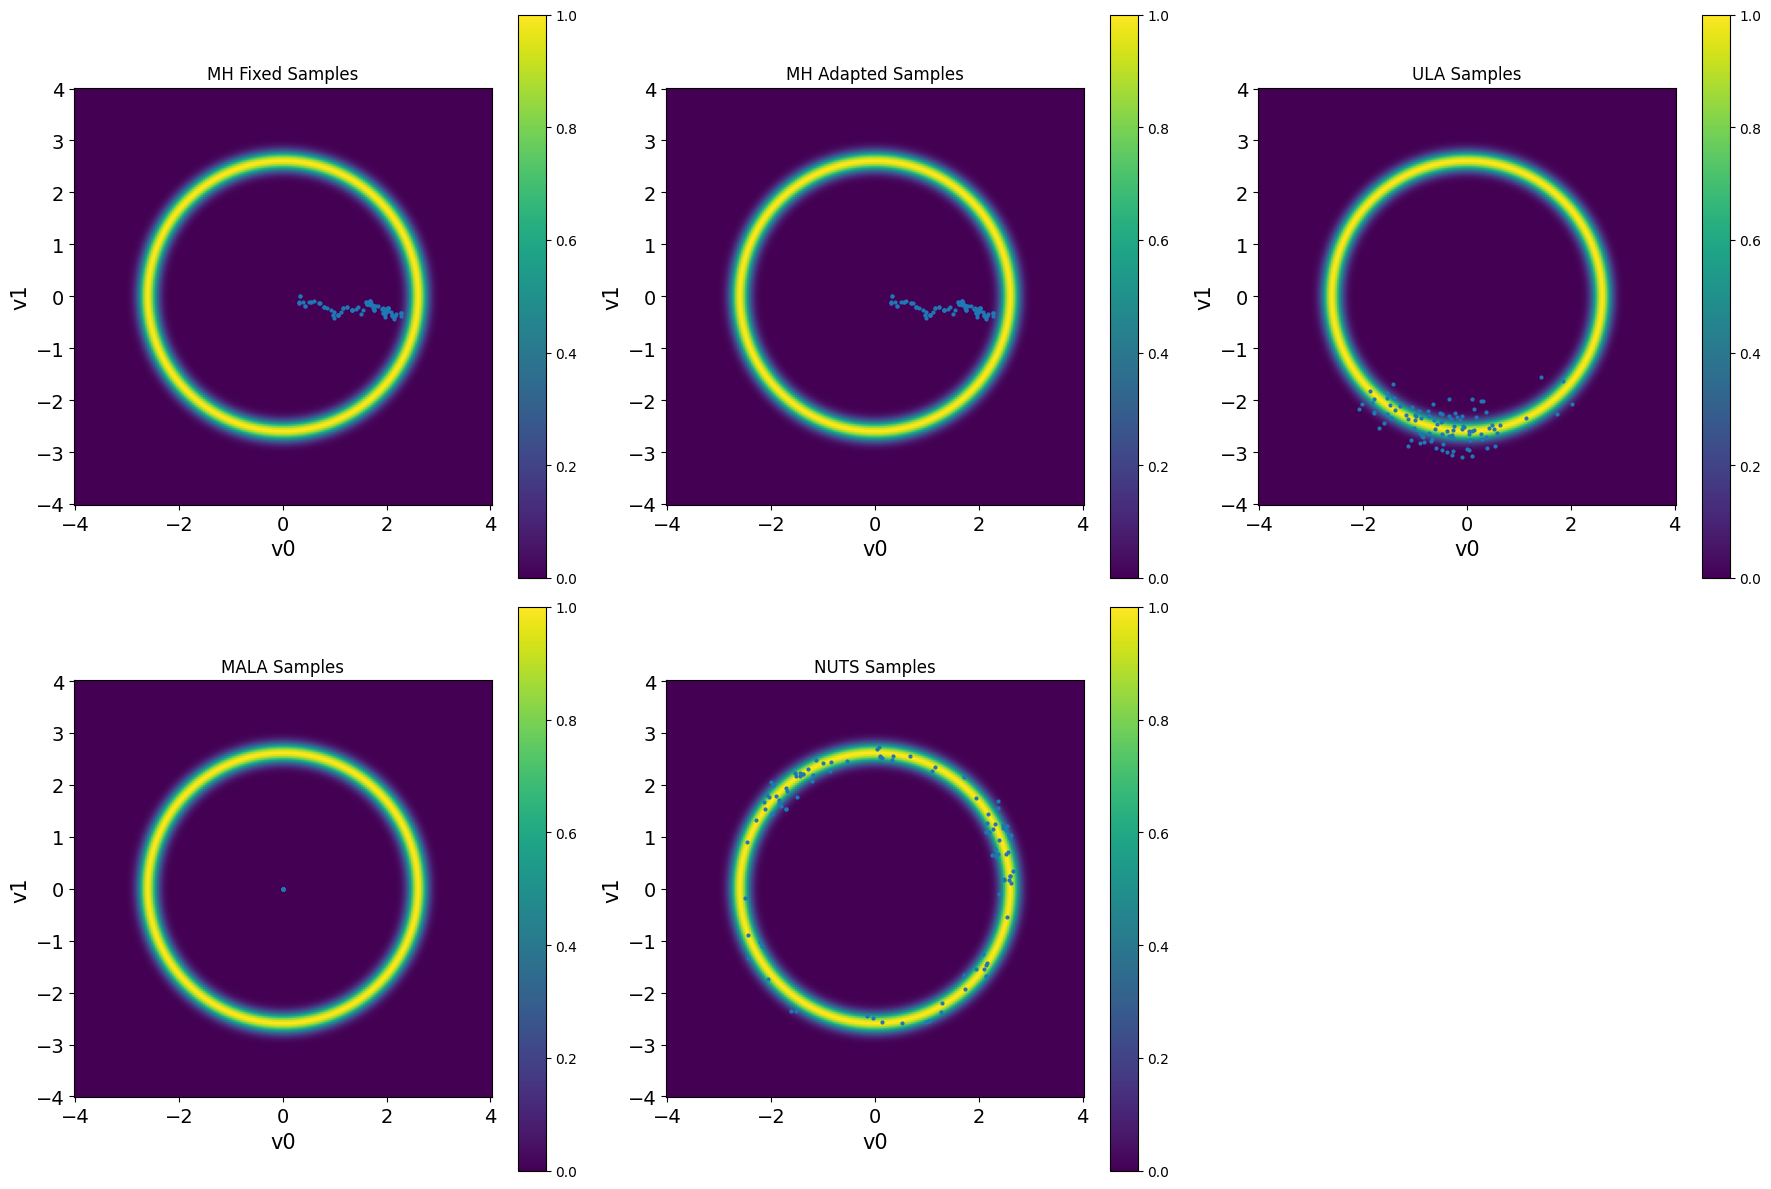

In [54]:
plot_sampling(target_donut, 0.05, 100, 10 ,x0 = np.array([0,0]), seed = 12)